## housekeeping

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import sys
import pandas as pd
import numpy as np
import anndata as ad
from cellxgene_census import download_source_h5ad

sys.path.append("/")
from src.sparse_autoencoder import SparseAutoencoder

In [2]:
plt.rcParams['axes.labelsize'] = 14  # Axis labels font size
plt.rcParams['axes.titlesize'] = 18  # Title font size
plt.rcParams['legend.fontsize'] = 12  # Legend font size

## query from database

In [3]:
# !curl -o /tmp/adata_wilk.h5ad https://datasets.cellxgene.cziscience.com/62d164a5-3645-4ae0-9b86-4a0fdea7028e.h5ad
# !curl -o /tmp/adata_arunachalam.h5ad https://datasets.cellxgene.cziscience.com/753caa81-61c5-4126-a61c-df2c546b16d1.h5ad
# !curl -o /tmp/adata_lee.h5ad https://datasets.cellxgene.cziscience.com/d48c74d4-3011-43cd-8e1c-0a68e3ea8647.h5ad

## read

In [4]:
adata_wilk = ad.read_h5ad("/tmp/adata_wilk.h5ad")
adata_arunachalam = ad.read_h5ad("/tmp/adata_arunachalam.h5ad")
# adata_lee = ad.read_h5ad("/tmp/adata_lee.h5ad")
combined_adata = ad.concat([adata_wilk,adata_arunachalam])

## plot umaps

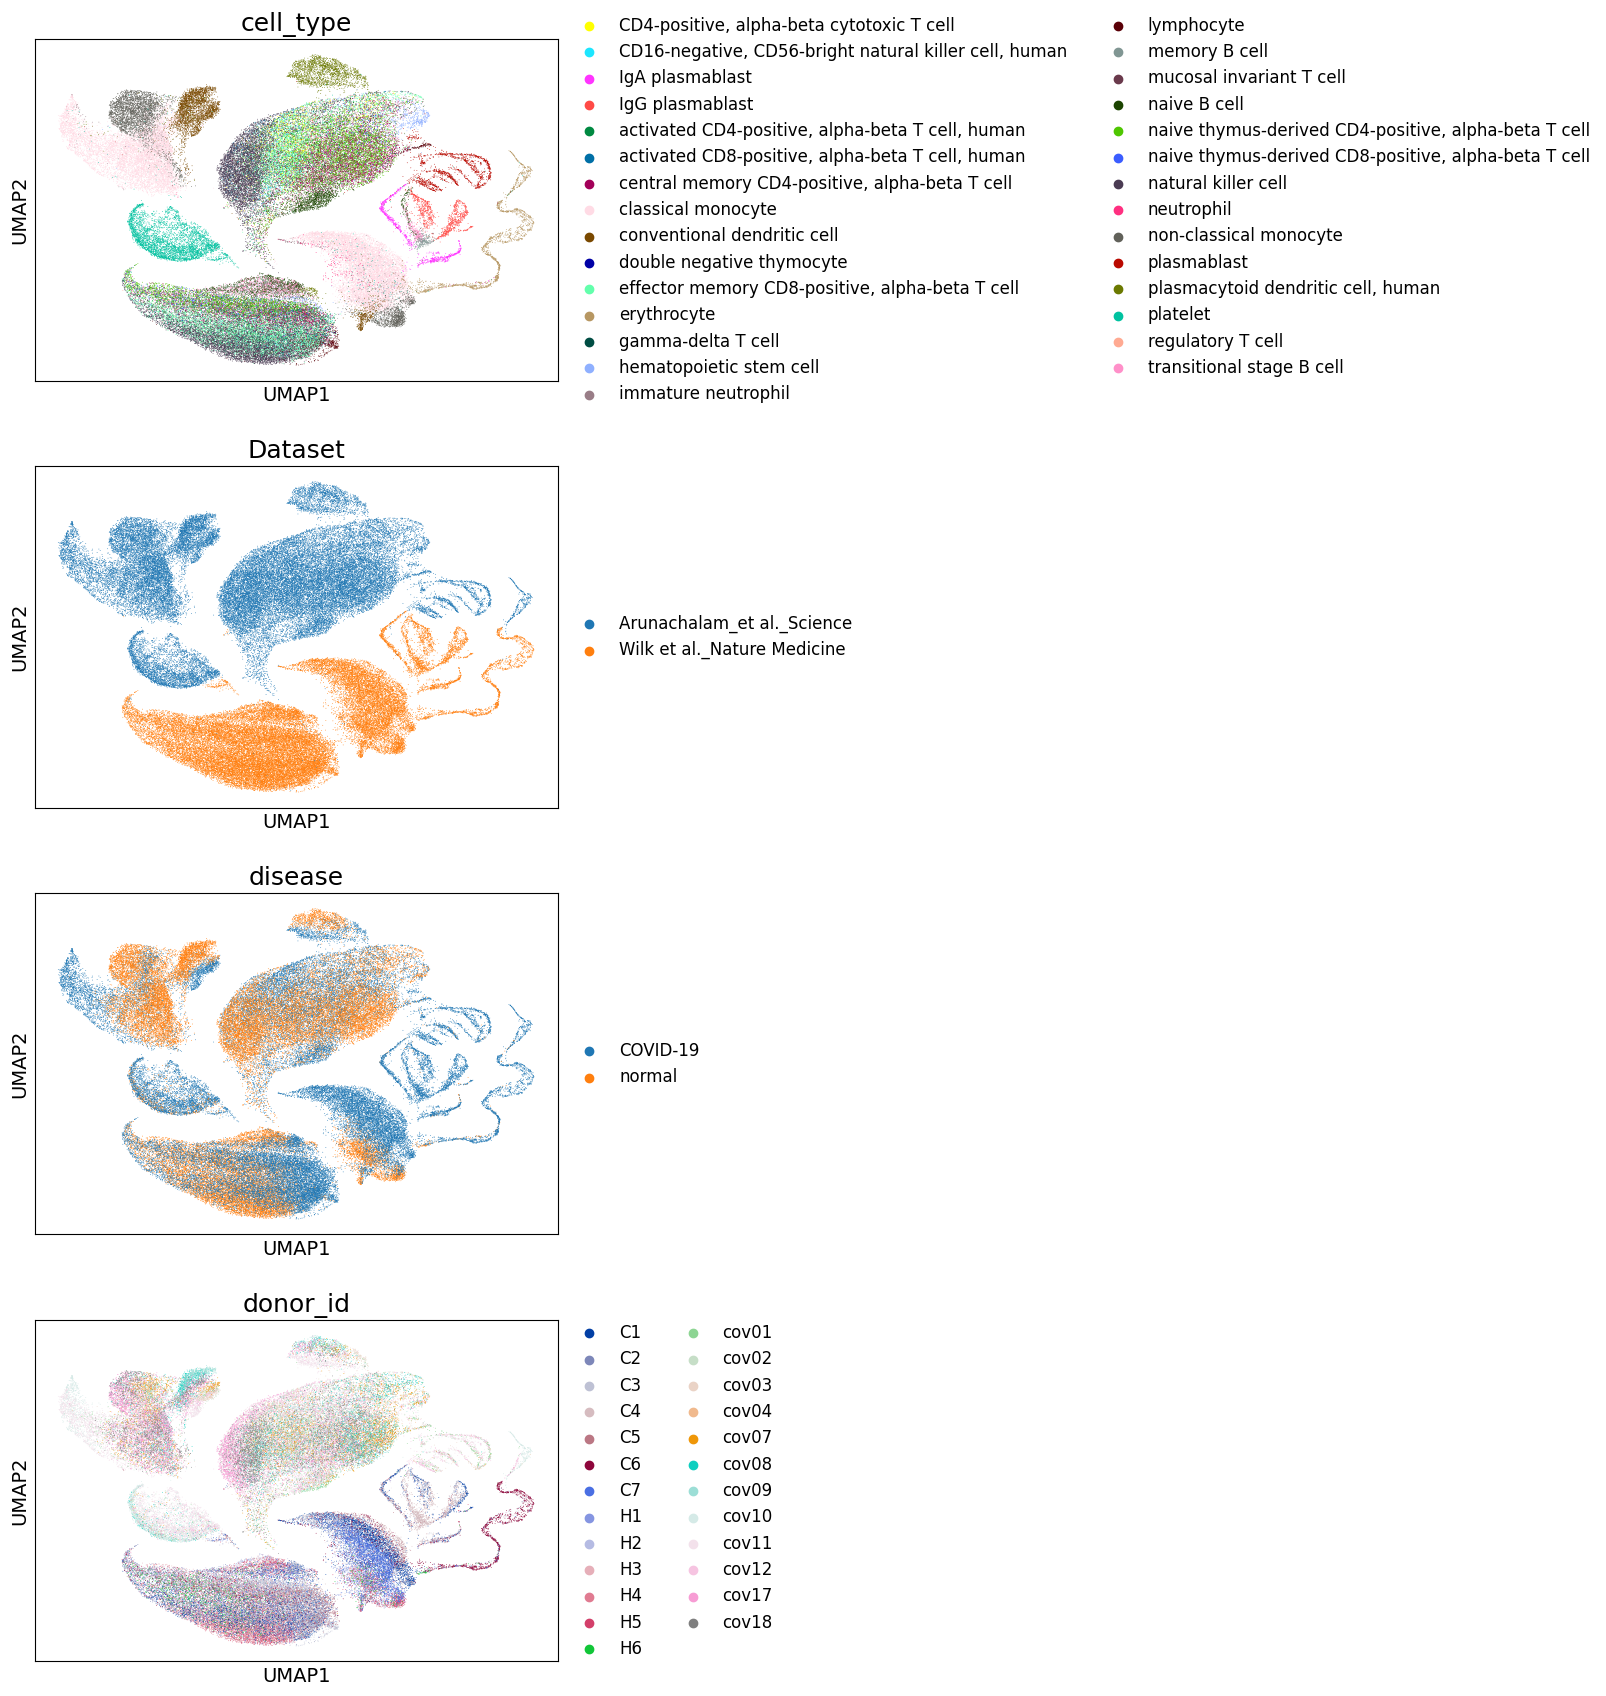

In [5]:
_adata_plotting = ad.AnnData(combined_adata.raw.X, combined_adata.obs, combined_adata.var)
sc.pp.pca(_adata_plotting)
sc.pp.neighbors(_adata_plotting, n_pcs=50)
sc.tl.umap(_adata_plotting)
sc.pl.umap(_adata_plotting, color=['cell_type', 'Dataset', 'disease', 'donor_id'], ncols=1,)

## prepocess data

In [7]:
# Step 1: Filter cells with low counts or genes
sc.pp.filter_cells(combined_adata, min_genes=200)
sc.pp.filter_genes(combined_adata, min_cells=3)

# Step 2: Normalize the data
sc.pp.normalize_total(combined_adata, target_sum=1e4)
sc.pp.log1p(combined_adata)

# Step 3: Find highly variable genes
# Identify highly variable genes across 'Dataset' and 'donor_id'
sc.pp.highly_variable_genes(
    combined_adata, 
    n_top_genes=10000, 
    subset=True, 
    flavor='seurat_v3', 
    batch_key='Dataset'
)

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## plot preprocessed umaps

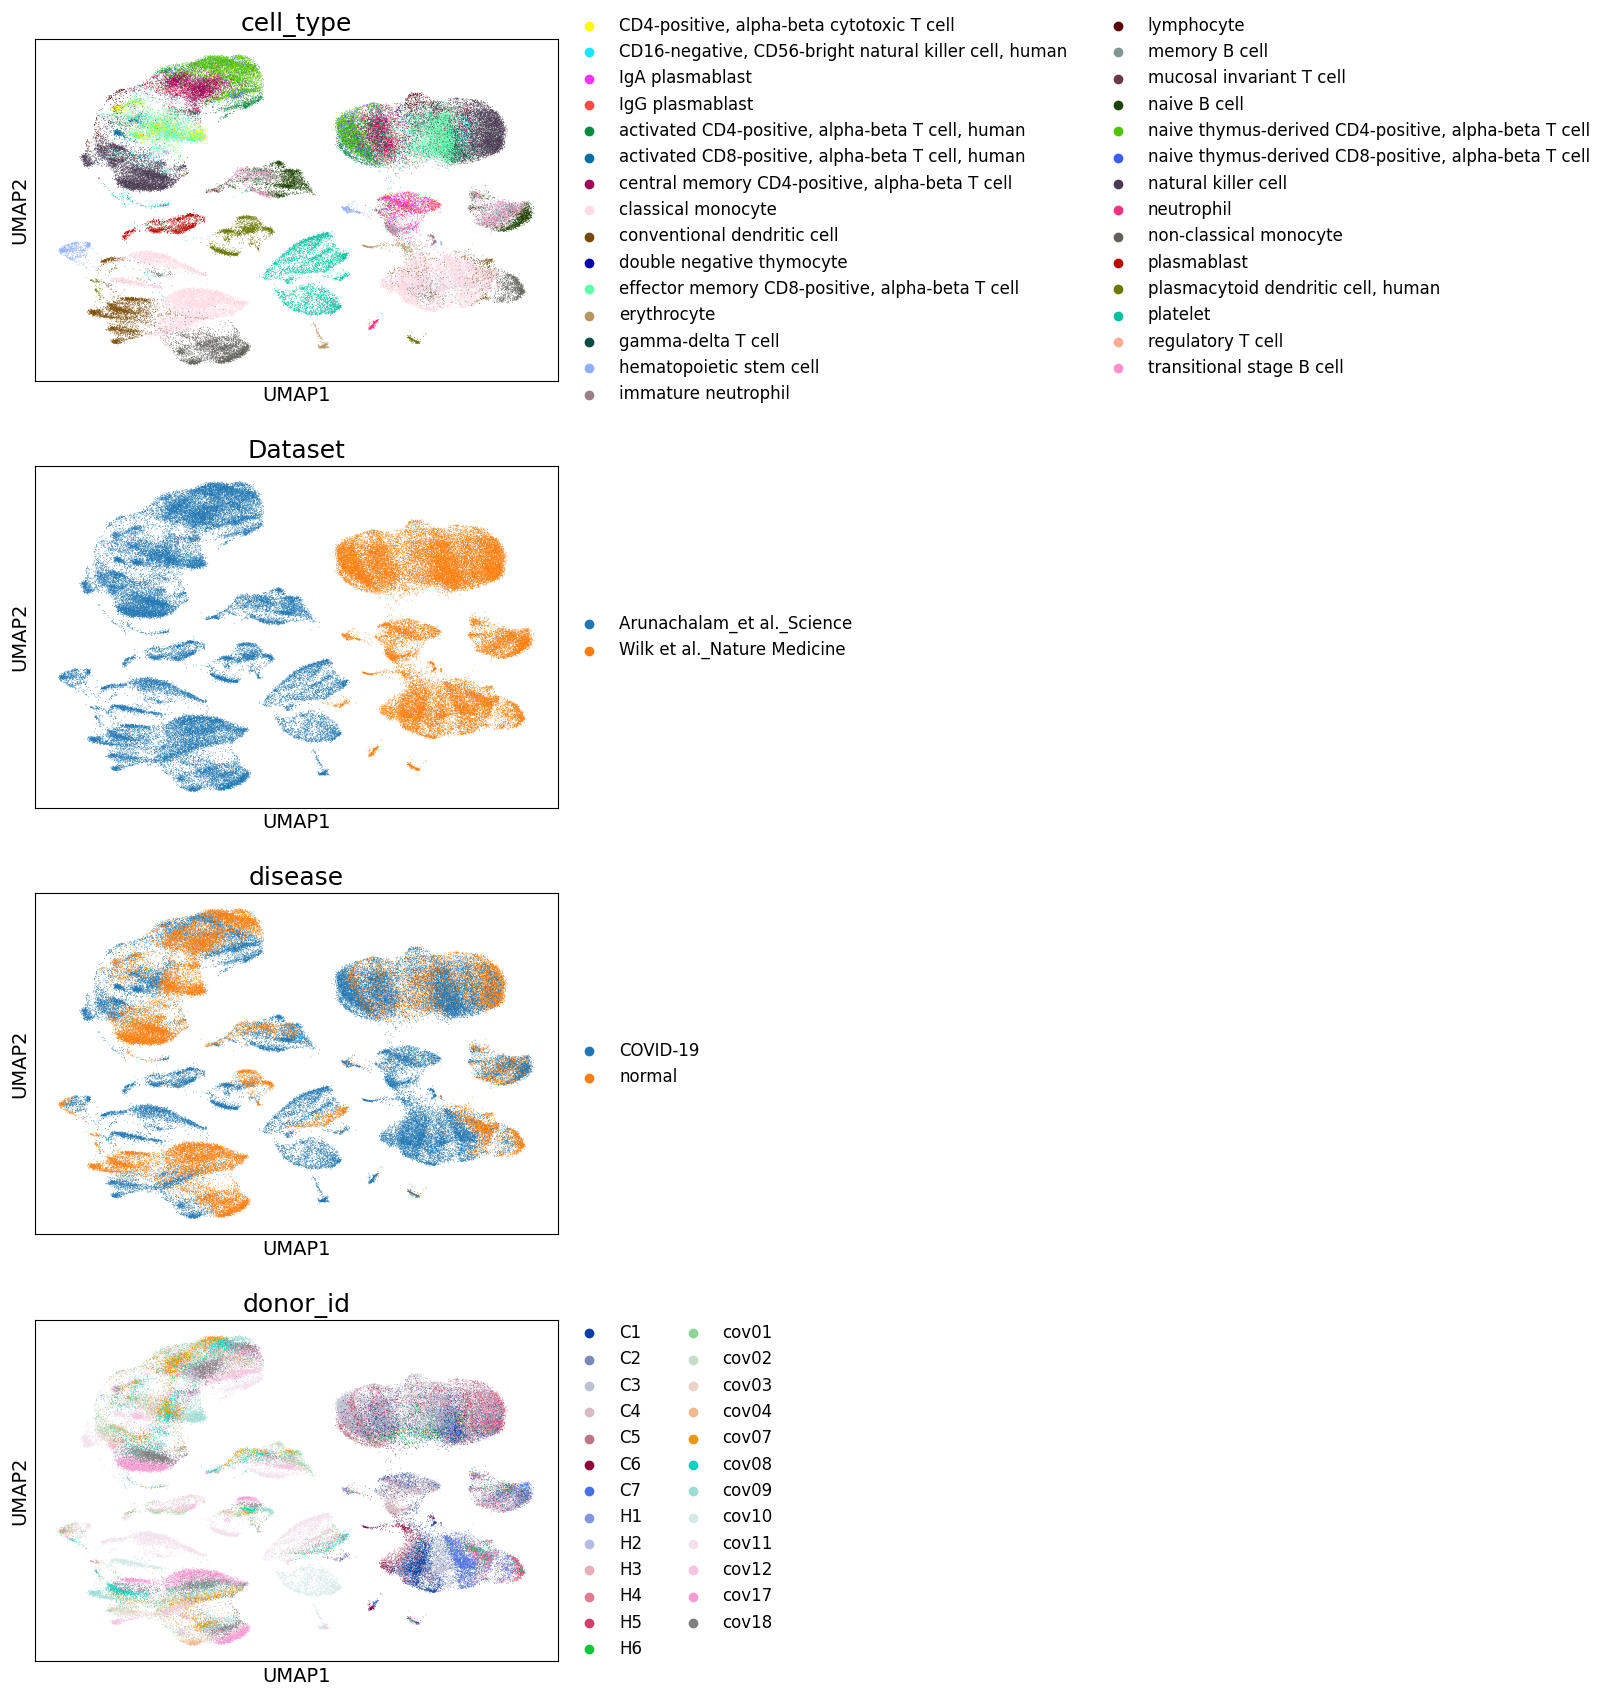

In [8]:
_adata_plotting = ad.AnnData(combined_adata.X, combined_adata.obs, combined_adata.var)
sc.pp.pca(_adata_plotting)
sc.pp.neighbors(_adata_plotting, n_pcs=50)
sc.tl.umap(_adata_plotting)
sc.pl.umap(_adata_plotting, color=['cell_type','Dataset','disease','donor_id'],ncols = 1)

## run scvi

In [9]:
# Step 1: Set up scVI
# Set up the AnnData object for scVI, treating Dataset as the batch and donor_id as an additional covariate
scvi.model.SCVI.setup_anndata(
    combined_adata,
    batch_key='Dataset',        # Batch effect to be corrected
    categorical_covariate_keys=['cell_type', 'disease']  # Preserved signals
)
# Step 2: Create the model
scvi_model = scvi.model.SCVI(combined_adata, n_latent=128)

# Step 3: Train the model
scvi_model.train()

# Obtain the latent representation
adata_scvi = ad.AnnData(scvi_model.get_latent_representation(), combined_adata.obs)

/opt/conda/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

Epoch 1/89:   0%|          | 0/89 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/89:   1%|          | 1/89 [00:05<08:02,  5.49s/it, v_num=1, train_loss_step=2.7e+3, train_loss_epoch=2.87e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/89:   2%|▏         | 2/89 [00:12<09:40,  6.67s/it, v_num=1, train_loss_step=2.65e+3, train_loss_epoch=2.72e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/89:   3%|▎         | 3/89 [00:20<10:06,  7.06s/it, v_num=1, train_loss_step=2.68e+3, train_loss_epoch=2.67e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/89:   4%|▍         | 4/89 [00:25<09:00,  6.36s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.64e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/89:   6%|▌         | 5/89 [00:31<08:19,  5.94s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.62e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/89:   7%|▋         | 6/89 [00:36<07:57,  5.76s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.6e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/89:   8%|▊         | 7/89 [00:41<07:37,  5.58s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.59e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/89:   9%|▉         | 8/89 [00:46<07:21,  5.45s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.58e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/89:  10%|█         | 9/89 [00:51<07:09,  5.37s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.57e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/89:  11%|█         | 10/89 [00:57<07:00,  5.32s/it, v_num=1, train_loss_step=2.52e+3, train_loss_epoch=2.56e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/89:  12%|█▏        | 11/89 [01:02<06:57,  5.35s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.56e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/89:  13%|█▎        | 12/89 [01:07<06:48,  5.30s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.55e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/89:  15%|█▍        | 13/89 [01:12<06:40,  5.27s/it, v_num=1, train_loss_step=2.58e+3, train_loss_epoch=2.55e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/89:  16%|█▌        | 14/89 [01:18<06:36,  5.29s/it, v_num=1, train_loss_step=2.58e+3, train_loss_epoch=2.55e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/89:  17%|█▋        | 15/89 [01:23<06:28,  5.25s/it, v_num=1, train_loss_step=2.63e+3, train_loss_epoch=2.54e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/89:  18%|█▊        | 16/89 [01:28<06:21,  5.22s/it, v_num=1, train_loss_step=2.48e+3, train_loss_epoch=2.54e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/89:  19%|█▉        | 17/89 [01:34<06:25,  5.35s/it, v_num=1, train_loss_step=2.47e+3, train_loss_epoch=2.54e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/89:  20%|██        | 18/89 [01:40<06:27,  5.46s/it, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.54e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/89:  21%|██▏       | 19/89 [01:45<06:22,  5.47s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/89:  22%|██▏       | 20/89 [01:50<06:07,  5.33s/it, v_num=1, train_loss_step=2.58e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/89:  24%|██▎       | 21/89 [01:56<06:09,  5.44s/it, v_num=1, train_loss_step=2.55e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/89:  25%|██▍       | 22/89 [02:02<06:15,  5.60s/it, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/89:  26%|██▌       | 23/89 [02:07<06:04,  5.52s/it, v_num=1, train_loss_step=2.45e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/89:  27%|██▋       | 24/89 [02:12<05:55,  5.47s/it, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/89:  28%|██▊       | 25/89 [02:18<05:45,  5.40s/it, v_num=1, train_loss_step=2.41e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/89:  29%|██▉       | 26/89 [02:23<05:38,  5.37s/it, v_num=1, train_loss_step=2.44e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/89:  30%|███       | 27/89 [02:28<05:31,  5.35s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/89:  31%|███▏      | 28/89 [02:33<05:25,  5.33s/it, v_num=1, train_loss_step=2.45e+3, train_loss_epoch=2.53e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/89:  33%|███▎      | 29/89 [02:39<05:21,  5.36s/it, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/89:  34%|███▎      | 30/89 [02:45<05:37,  5.73s/it, v_num=1, train_loss_step=2.48e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/89:  35%|███▍      | 31/89 [02:52<05:40,  5.87s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/89:  36%|███▌      | 32/89 [02:56<05:16,  5.55s/it, v_num=1, train_loss_step=2.51e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/89:  37%|███▋      | 33/89 [03:02<05:03,  5.41s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/89:  38%|███▊      | 34/89 [03:07<04:55,  5.38s/it, v_num=1, train_loss_step=2.7e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/89:  39%|███▉      | 35/89 [03:12<04:47,  5.32s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/89:  40%|████      | 36/89 [03:17<04:35,  5.20s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/89:  42%|████▏     | 37/89 [03:22<04:25,  5.11s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/89:  43%|████▎     | 38/89 [03:27<04:18,  5.07s/it, v_num=1, train_loss_step=2.49e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/89:  44%|████▍     | 39/89 [03:32<04:11,  5.02s/it, v_num=1, train_loss_step=2.51e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/89:  45%|████▍     | 40/89 [03:37<04:08,  5.08s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/89:  46%|████▌     | 41/89 [03:42<04:09,  5.20s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/89:  47%|████▋     | 42/89 [03:48<04:03,  5.17s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/89:  48%|████▊     | 43/89 [03:53<03:58,  5.18s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/89:  49%|████▉     | 44/89 [03:58<03:50,  5.13s/it, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/89:  51%|█████     | 45/89 [04:03<03:48,  5.18s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/89:  52%|█████▏    | 46/89 [04:08<03:42,  5.19s/it, v_num=1, train_loss_step=2.48e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/89:  53%|█████▎    | 47/89 [04:14<03:40,  5.25s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/89:  54%|█████▍    | 48/89 [04:19<03:32,  5.17s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/89:  55%|█████▌    | 49/89 [04:24<03:28,  5.21s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/89:  56%|█████▌    | 50/89 [04:29<03:24,  5.24s/it, v_num=1, train_loss_step=2.62e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/89:  57%|█████▋    | 51/89 [04:35<03:18,  5.23s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/89:  58%|█████▊    | 52/89 [04:40<03:17,  5.34s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/89:  60%|█████▉    | 53/89 [04:46<03:17,  5.48s/it, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/89:  61%|██████    | 54/89 [04:51<03:08,  5.39s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/89:  62%|██████▏   | 55/89 [04:56<03:03,  5.40s/it, v_num=1, train_loss_step=2.44e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/89:  63%|██████▎   | 56/89 [05:02<02:57,  5.37s/it, v_num=1, train_loss_step=2.52e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/89:  64%|██████▍   | 57/89 [05:07<02:50,  5.32s/it, v_num=1, train_loss_step=2.44e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/89:  65%|██████▌   | 58/89 [05:12<02:41,  5.22s/it, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/89:  66%|██████▋   | 59/89 [05:17<02:36,  5.21s/it, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/89:  67%|██████▋   | 60/89 [05:22<02:31,  5.21s/it, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/89:  69%|██████▊   | 61/89 [05:28<02:25,  5.21s/it, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.52e+3] 

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/89:  70%|██████▉   | 62/89 [05:33<02:22,  5.27s/it, v_num=1, train_loss_step=2.48e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/89:  71%|███████   | 63/89 [05:38<02:17,  5.31s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/89:  72%|███████▏  | 64/89 [05:44<02:14,  5.39s/it, v_num=1, train_loss_step=2.46e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/89:  73%|███████▎  | 65/89 [05:49<02:08,  5.34s/it, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/89:  74%|███████▍  | 66/89 [05:55<02:03,  5.36s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/89:  75%|███████▌  | 67/89 [06:00<01:57,  5.34s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/89:  76%|███████▋  | 68/89 [06:05<01:50,  5.28s/it, v_num=1, train_loss_step=2.55e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/89:  78%|███████▊  | 69/89 [06:10<01:46,  5.30s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/89:  79%|███████▊  | 70/89 [06:16<01:43,  5.44s/it, v_num=1, train_loss_step=2.49e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/89:  80%|███████▉  | 71/89 [06:22<01:39,  5.53s/it, v_num=1, train_loss_step=2.52e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/89:  81%|████████  | 72/89 [06:27<01:33,  5.49s/it, v_num=1, train_loss_step=2.52e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/89:  82%|████████▏ | 73/89 [06:33<01:29,  5.61s/it, v_num=1, train_loss_step=2.52e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/89:  83%|████████▎ | 74/89 [06:39<01:24,  5.61s/it, v_num=1, train_loss_step=2.42e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/89:  84%|████████▍ | 75/89 [06:44<01:16,  5.49s/it, v_num=1, train_loss_step=2.58e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/89:  85%|████████▌ | 76/89 [06:49<01:09,  5.34s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/89:  87%|████████▋ | 77/89 [06:54<01:03,  5.33s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/89:  88%|████████▊ | 78/89 [07:01<01:02,  5.68s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/89:  89%|████████▉ | 79/89 [07:06<00:55,  5.60s/it, v_num=1, train_loss_step=2.36e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/89:  90%|████████▉ | 80/89 [07:12<00:50,  5.58s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/89:  91%|█████████ | 81/89 [07:17<00:44,  5.51s/it, v_num=1, train_loss_step=2.45e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/89:  92%|█████████▏| 82/89 [07:22<00:38,  5.48s/it, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/89:  93%|█████████▎| 83/89 [07:28<00:32,  5.49s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/89:  94%|█████████▍| 84/89 [07:33<00:27,  5.44s/it, v_num=1, train_loss_step=2.56e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/89:  96%|█████████▌| 85/89 [07:39<00:21,  5.45s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/89:  97%|█████████▋| 86/89 [07:44<00:15,  5.32s/it, v_num=1, train_loss_step=2.51e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/89:  98%|█████████▊| 87/89 [07:49<00:10,  5.22s/it, v_num=1, train_loss_step=2.47e+3, train_loss_epoch=2.52e+3]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/89:  99%|█████████▉| 88/89 [07:54<00:05,  5.18s/it, v_num=1, train_loss_step=2.53e+3, train_loss_epoch=2523.25]

/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/opt/conda/lib/python3.11/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/89: 100%|██████████| 89/89 [07:59<00:00,  5.19s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 89/89: 100%|██████████| 89/89 [07:59<00:00,  5.39s/it, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.52e+3]


## plot scvi corrected data

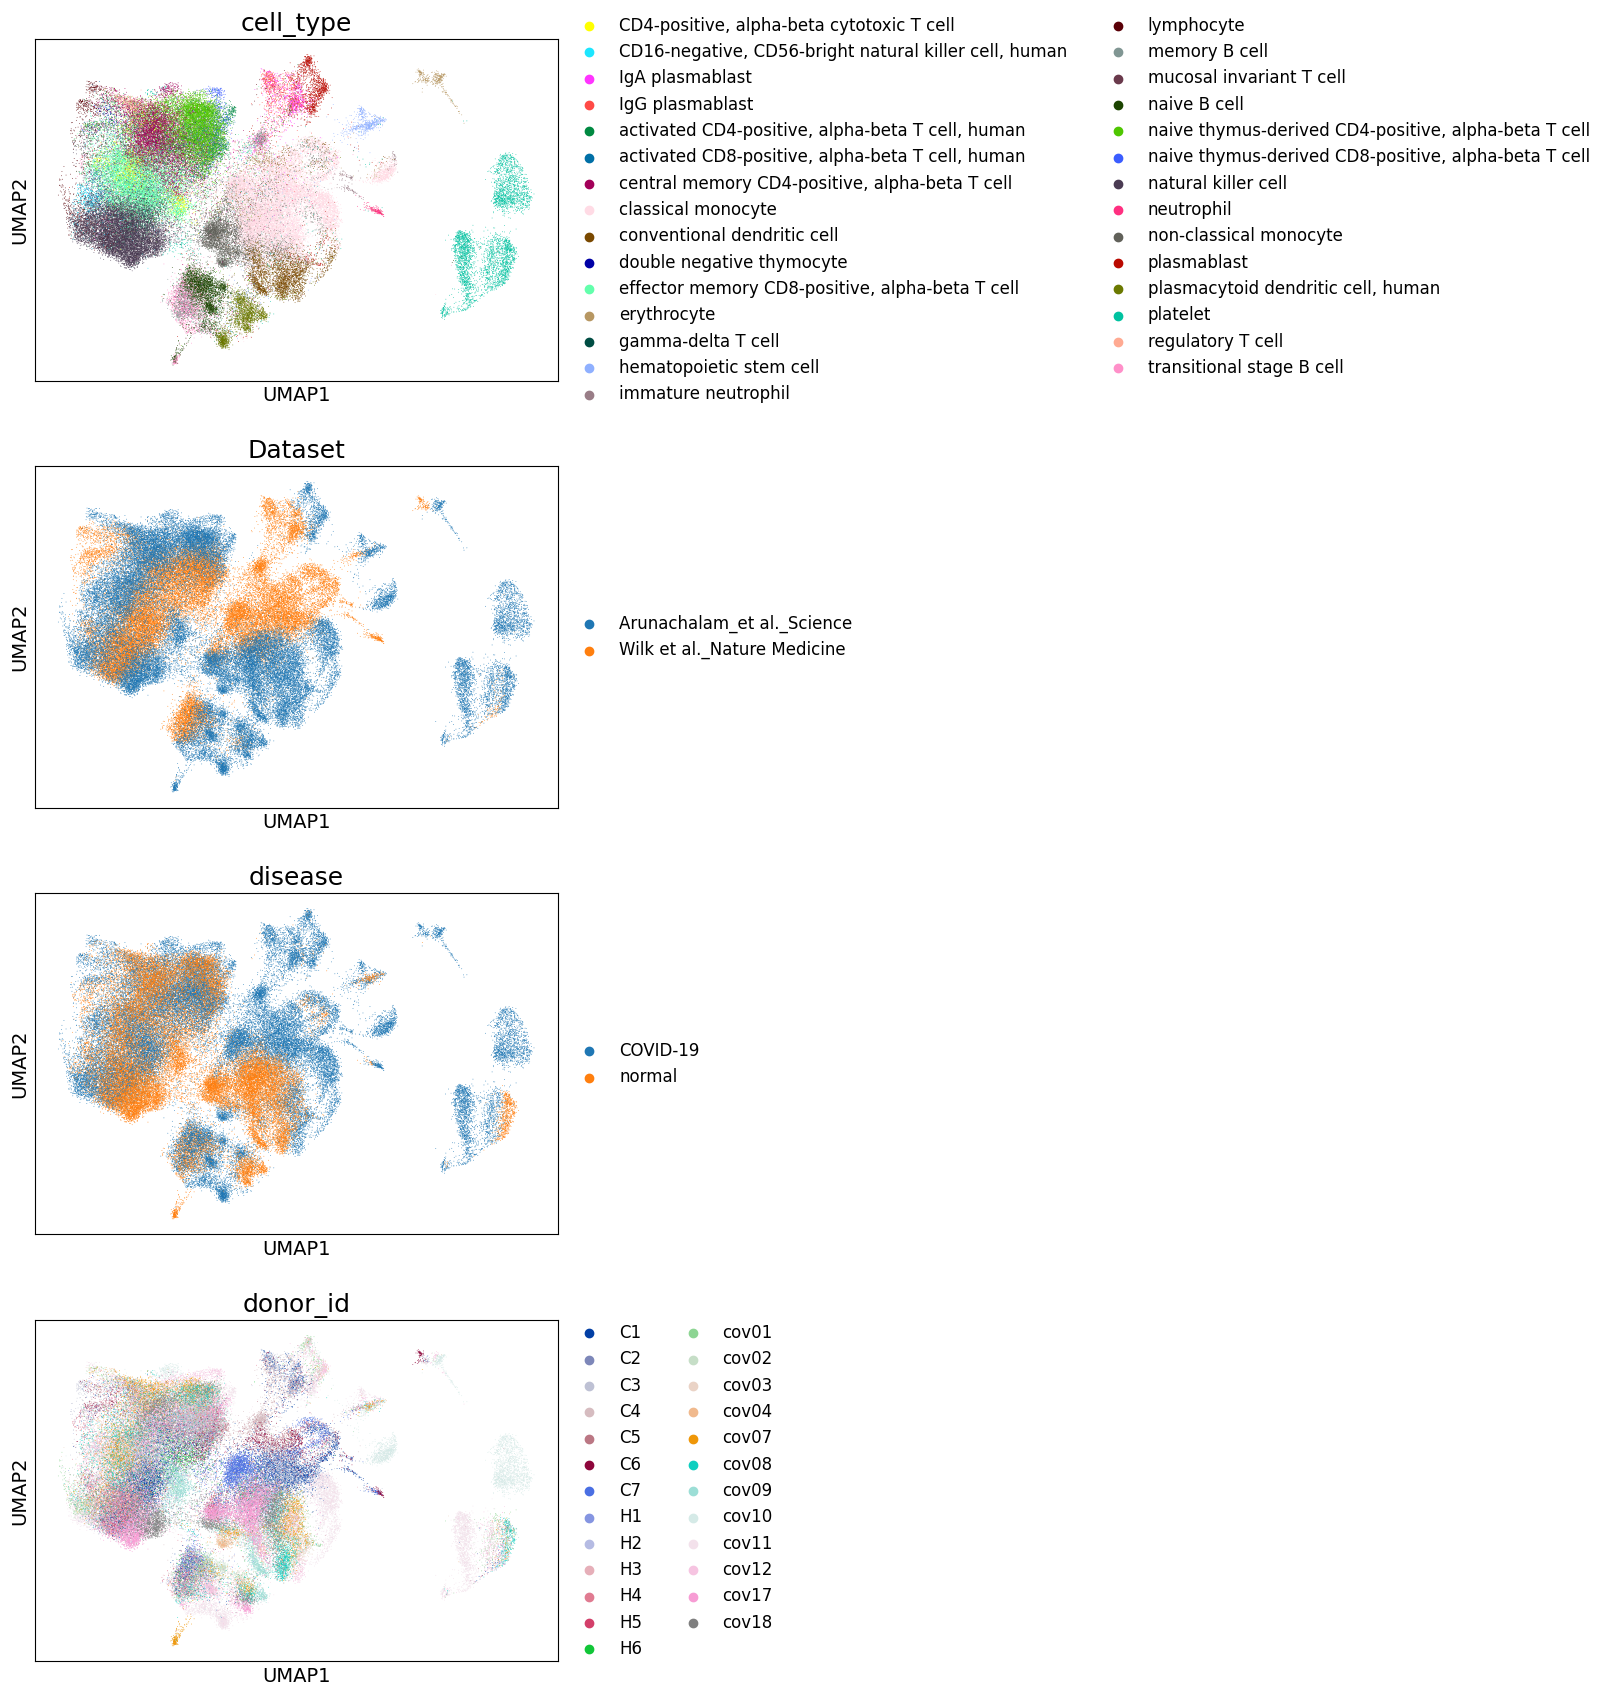

In [10]:
_adata_plotting = ad.AnnData(adata_scvi.X, adata_scvi.obs, adata_scvi.var)
sc.pp.pca(_adata_plotting)
sc.pp.neighbors(_adata_plotting, n_pcs=50)
sc.tl.umap(_adata_plotting)
sc.pl.umap(_adata_plotting, color=['cell_type','Dataset','disease','donor_id'],ncols = 1)

In [ ]:
adata_scvi.write_h5ad("./scvi_embedding.h5ad")